In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.stats import trim_mean, kurtosis, skew

# Dataset Information:

*   The Customer Churn table contains information on all 7,043 customers from a Telecommunications company in California in Q2 2022
*   Each record represents one customer, and contains details about their demographics, location, tenure, subscription services, status for the quarter (joined, stayed, or churned), and more!
* The Zip Code Population table contains complimentary information on the estimated populations for the California zip codes in the Customer Churn table

***I am assuming the role of a BI Consultant for Maven Communications, a California-based Telecommunications company and my main objective is to
improve retention by identifying high value customers and churn risks, and will present my findings first by publishing my code on github and my online portfolio, and secondly include a single page report or dashboard***





In [3]:
df_churn = pd.read_csv('/content/telecom_customer_churn.csv')
df_churn.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
df_dict = pd.read_csv('/content/telecom_data_dictionary.csv', encoding='ISO-8859-1')
df_population = pd.read_csv('/content/telecom_zipcode_population.csv', encoding='ISO-8859-1')

In [5]:
df_churn.isnull().sum()

,0
Customer ID,0
Gender,0
Age,0
Married,0
Number of Dependents,0
City,0
Zip Code,0
Latitude,0
Longitude,0
Number of Referrals,0


In [6]:
print(df_churn.info())
print(df_churn.head())
print(df_churn.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [7]:
df_churn.nunique()

,0
Customer ID,7043
Gender,2
Age,62
Married,2
Number of Dependents,10
City,1106
Zip Code,1626
Latitude,1626
Longitude,1625
Number of Referrals,12


**Dropping Columns**

*Customer ID:* Unique identifier for each customer and doesn't carry any predictive value for the target variable which in this case is churn so keeping it in the model could introduce noise, which I wan't to avoid.

*City, Zip Code, Latitude, Longitude:* These are geographical features and as seen by the code line below has has many unique values. Since my model currently doesn't focus on  location-sensitive prediction of churn, these columns may add unnecessary complexity.

In [8]:
df_churn = df_churn.drop(['Customer ID', 'City', 'Latitude', 'Longitude'], axis=1)

In [9]:
df_churn.head()

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,Female,37,Yes,0,93225,2,9,NaN,Yes,42.39,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,Male,46,No,0,91206,0,9,NaN,Yes,10.69,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,Male,50,No,0,92627,0,4,Offer E,Yes,33.65,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,Male,78,Yes,0,94553,1,13,Offer D,Yes,27.82,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,Female,75,Yes,0,93010,3,3,NaN,Yes,7.38,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [10]:
print(df_population.head())
print(df_population.info())

   Zip Code  Population
0     90001       54492
1     90002       44586
2     90003       58198
3     90004       67852
4     90005       43019
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Zip Code    1671 non-null   int64
 1   Population  1671 non-null   int64
dtypes: int64(2)
memory usage: 26.2 KB
None


In [11]:
df_churn = pd.merge(df_churn, df_population, how='left', on='Zip Code')
df_churn.head()

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason,Population
0,Female,37,Yes,0,93225,2,9,NaN,Yes,42.39,...,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN,4498
1,Male,46,No,0,91206,0,9,NaN,Yes,10.69,...,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN,31297
2,Male,50,No,0,92627,0,4,Offer E,Yes,33.65,...,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices,62069
3,Male,78,Yes,0,94553,1,13,Offer D,Yes,27.82,...,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction,46677
4,Female,75,Yes,0,93010,3,3,NaN,Yes,7.38,...,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability,42853


In [12]:
#df_churn.drop(columns=['Population_x', 'Population_y'], inplace=True)

In [13]:
print(df_churn.head())
print(df_churn.info())

   Gender  Age Married  Number of Dependents  Zip Code  Number of Referrals  \
0  Female   37     Yes                     0     93225                    2   
1    Male   46      No                     0     91206                    0   
2    Male   50      No                     0     92627                    0   
3    Male   78     Yes                     0     94553                    1   
4  Female   75     Yes                     0     93010                    3   

   Tenure in Months    Offer Phone Service  Avg Monthly Long Distance Charges  \
0                 9      NaN           Yes                              42.39   
1                 9      NaN           Yes                              10.69   
2                 4  Offer E           Yes                              33.65   
3                13  Offer D           Yes                              27.82   
4                 3      NaN           Yes                               7.38   

   ... Monthly Charge Total Charges To

In [14]:
df_churn['Population'].fillna(df_churn['Population'].median(), inplace=True)

Building a Predictive Model so dropping Churn Category and Churn reason as they are available after customers have churned and not at the time of predictive modeling.

In [15]:
df_churn = df_churn.drop(['Churn Category', 'Churn Reason'], axis=1)

#Exploratory Data Analysis (EDA) to uncover patterns and insights

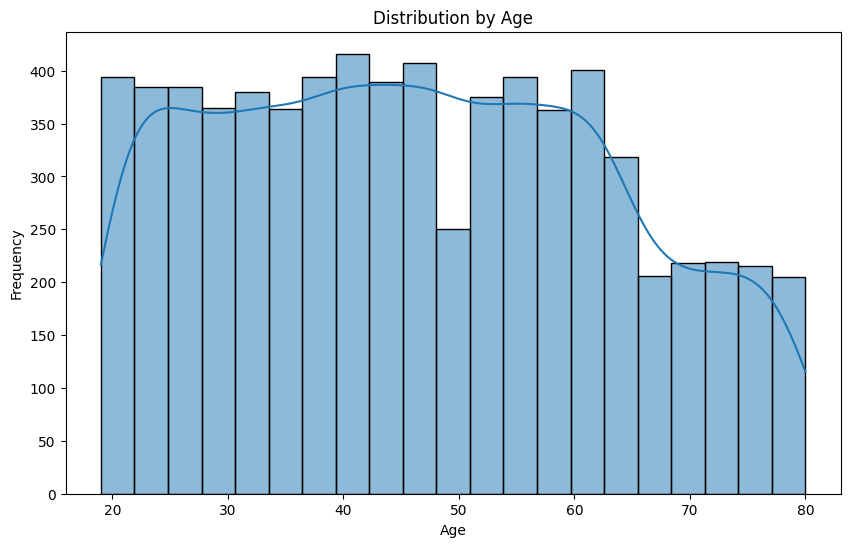

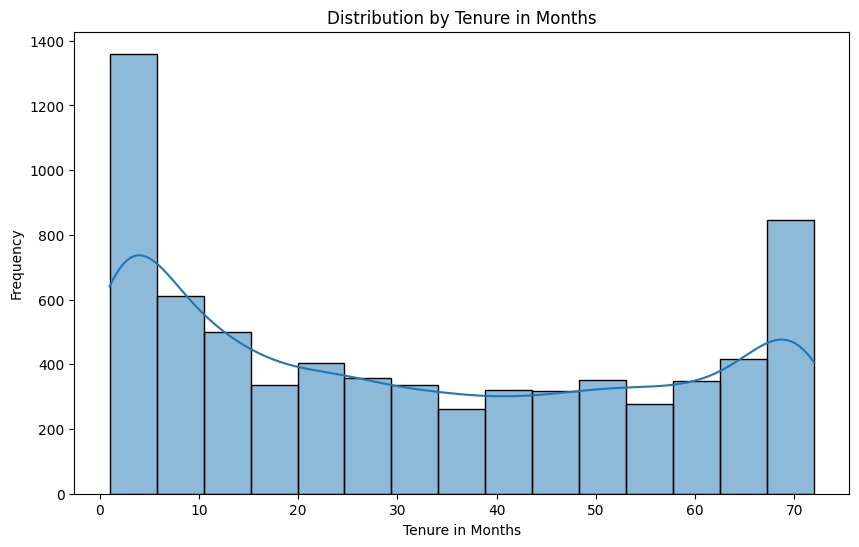

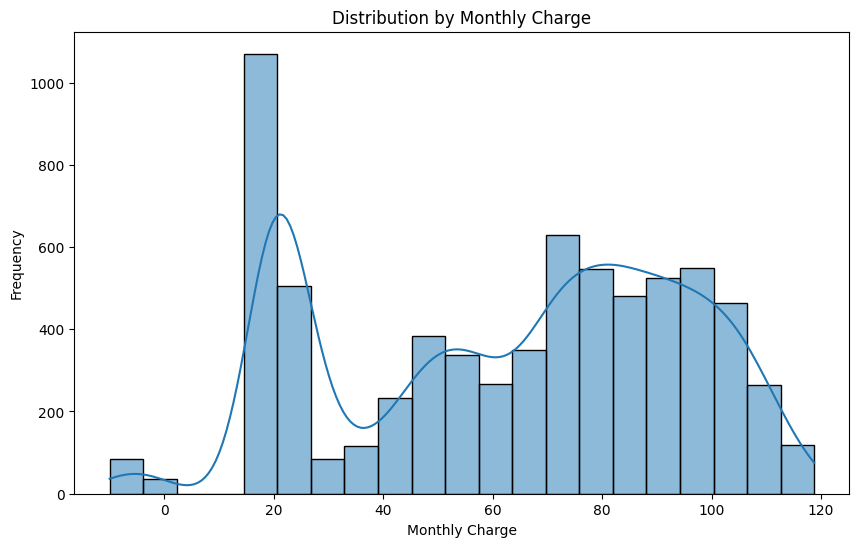

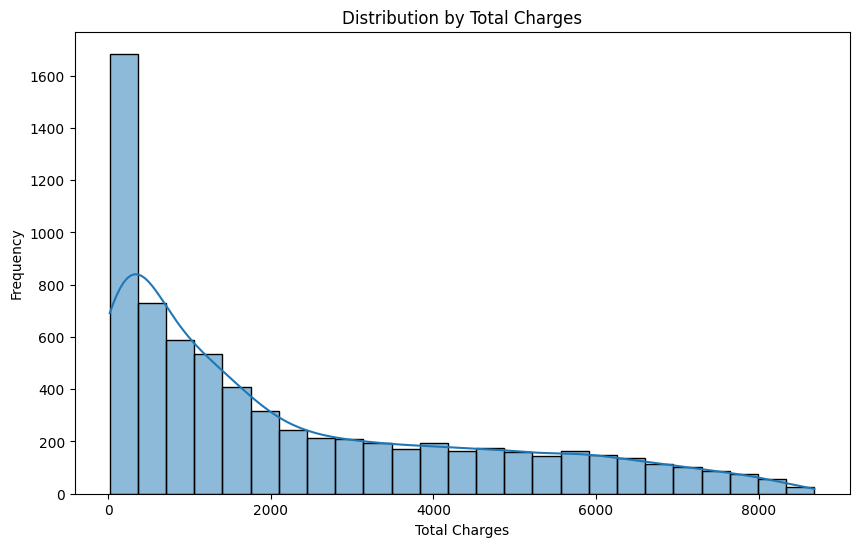

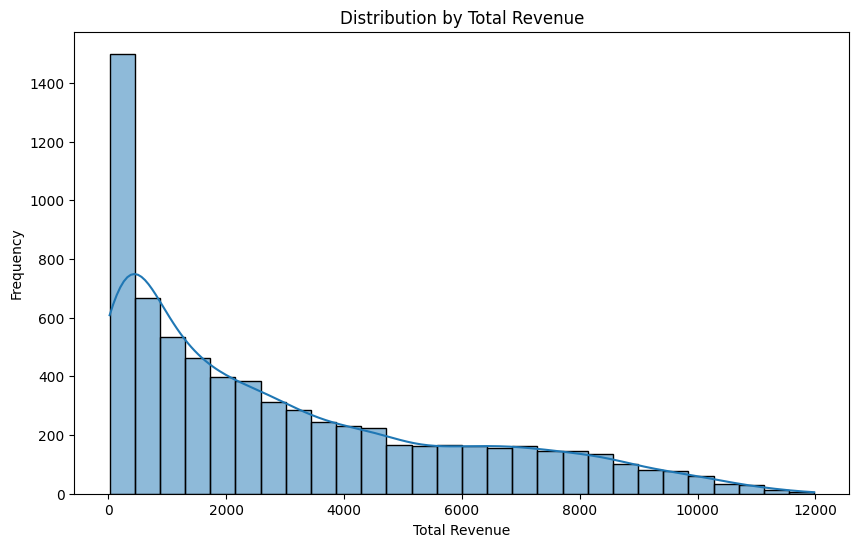

In [16]:
numerical_features = ['Age', 'Tenure in Months', 'Monthly Charge', 'Total Charges', 'Total Revenue']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_churn[feature], kde=True)
    plt.title(f'Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


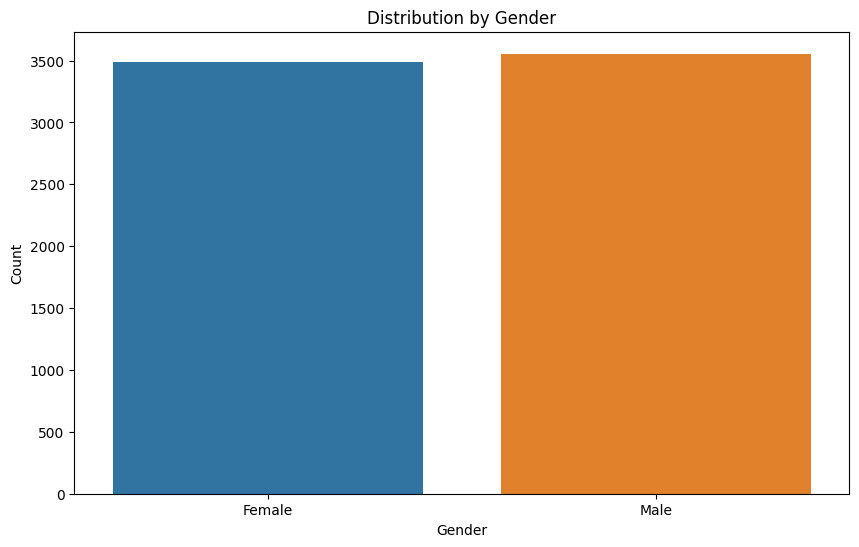

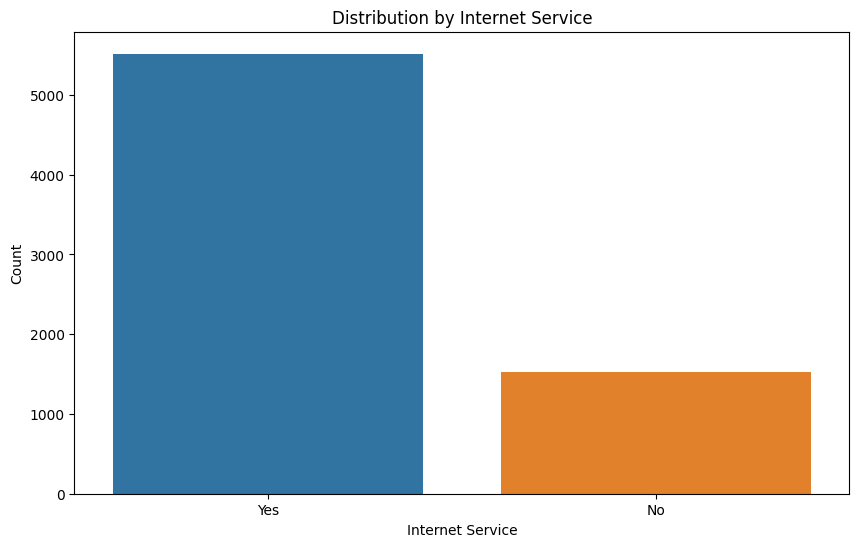

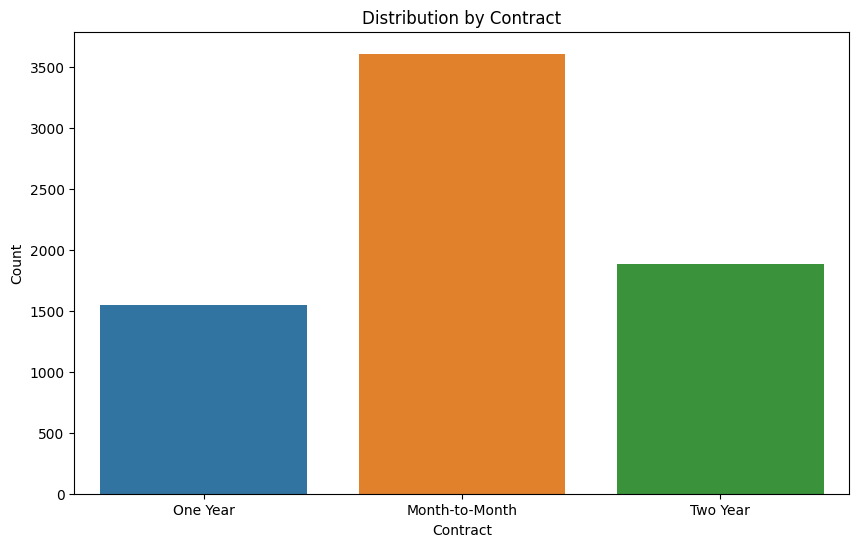

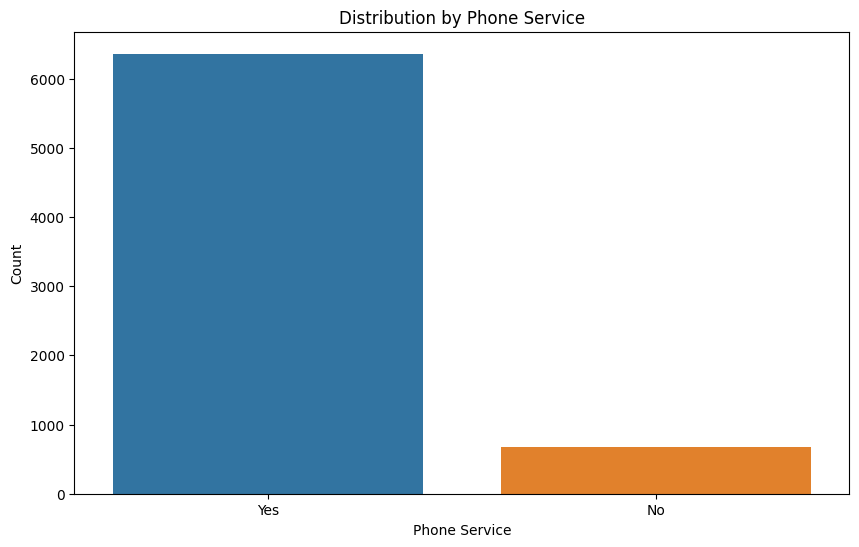

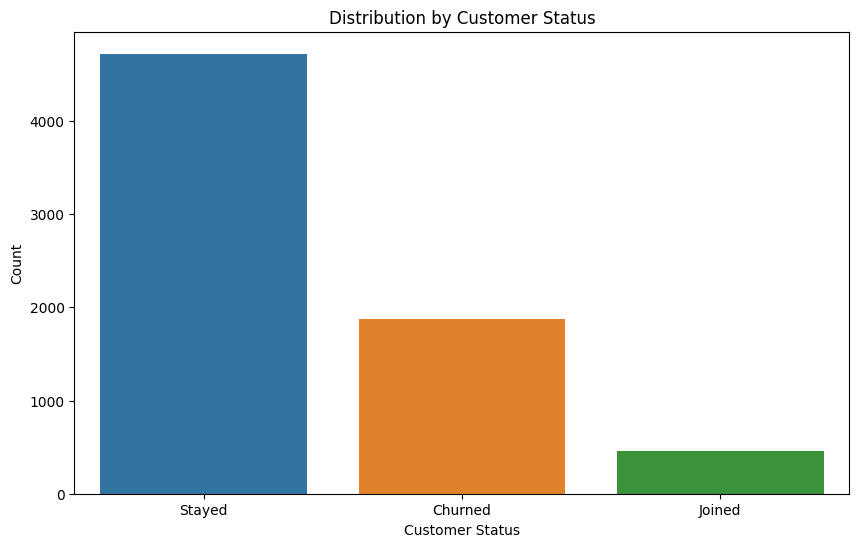

In [17]:
categorical_features = ['Gender', 'Internet Service', 'Contract', 'Phone Service', 'Customer Status']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=df_churn, hue=feature)
    plt.title(f'Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


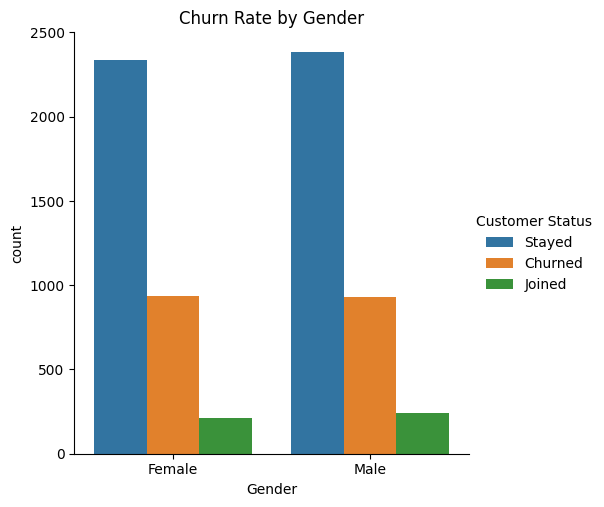

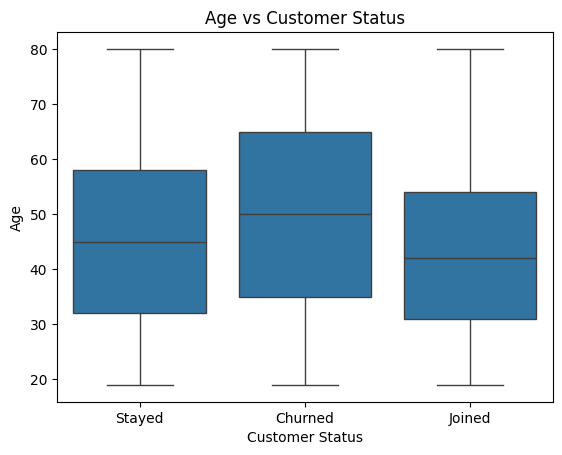

In [18]:
sns.catplot(x="Gender", hue="Customer Status", kind="count", data=df_churn)
plt.title("Churn Rate by Gender")
plt.show()

sns.boxplot(x='Customer Status', y='Age', data=df_churn)
plt.title('Age vs Customer Status')
plt.show()

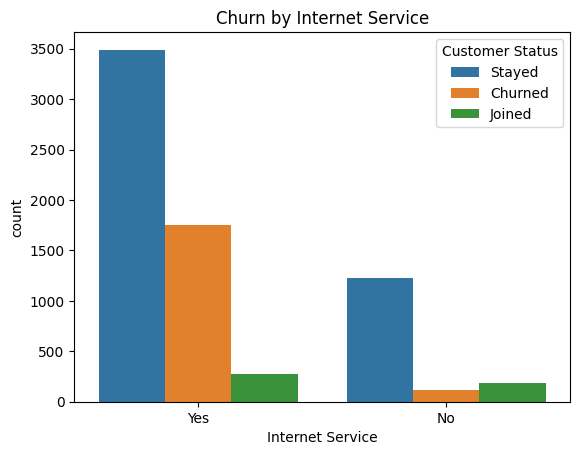

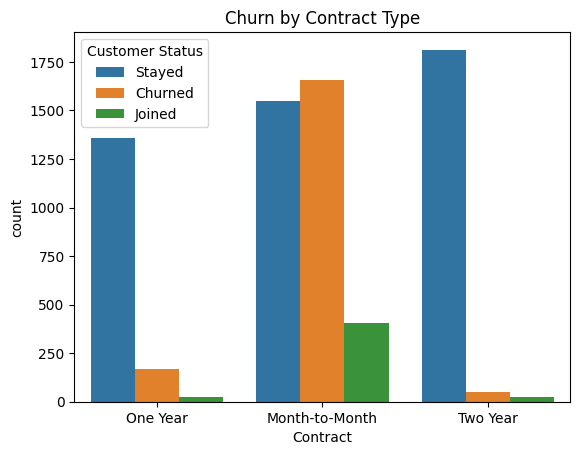

In [19]:
sns.countplot(x='Internet Service', hue='Customer Status', data=df_churn)
plt.title('Churn by Internet Service')
plt.show()

sns.countplot(x='Contract', hue='Customer Status', data=df_churn)
plt.title('Churn by Contract Type')
plt.show()

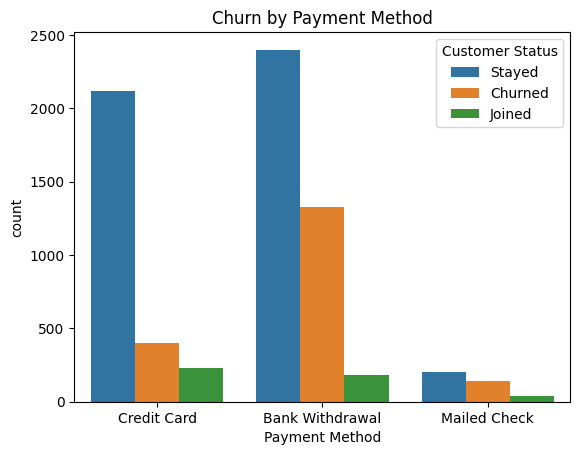

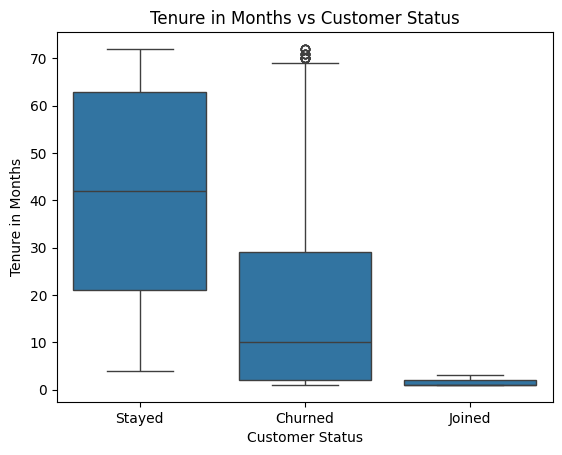

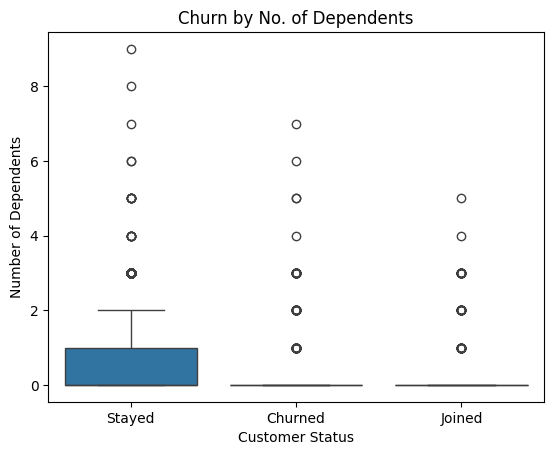

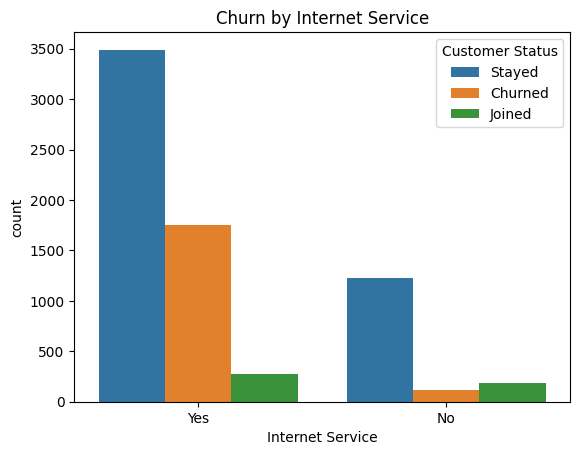

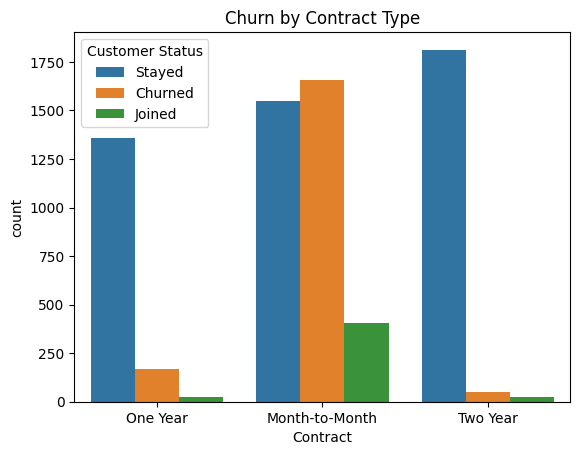

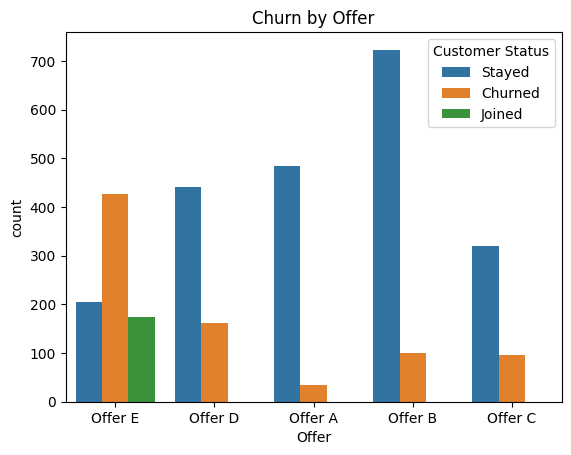

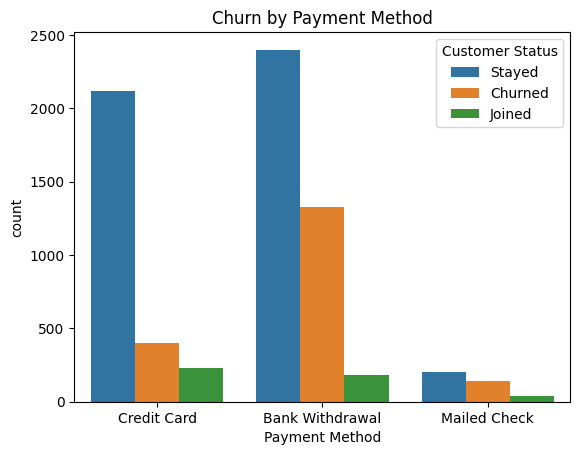

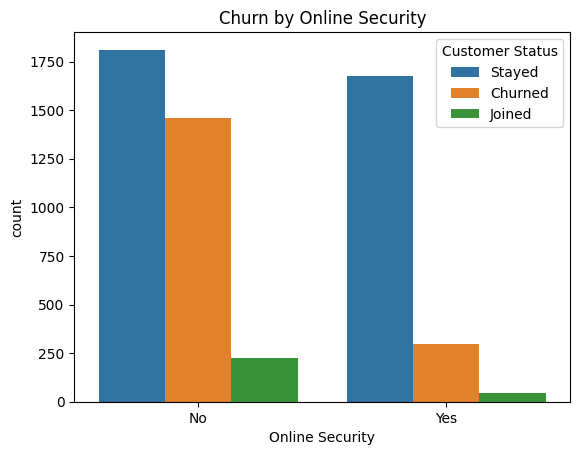

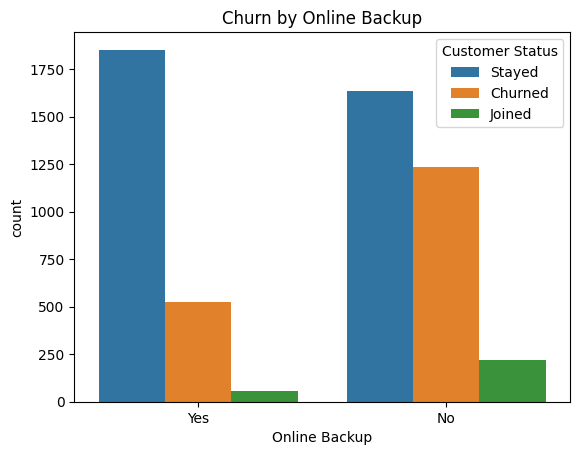

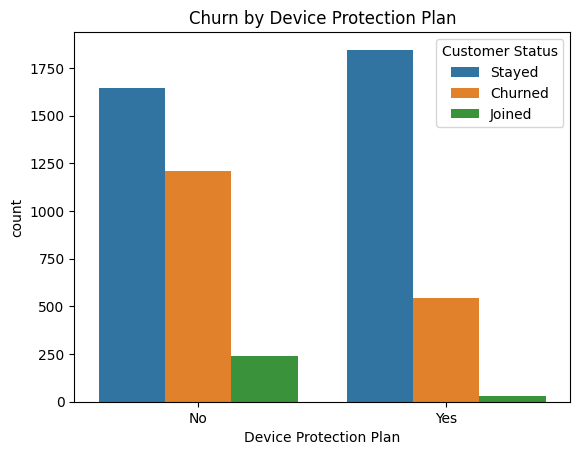

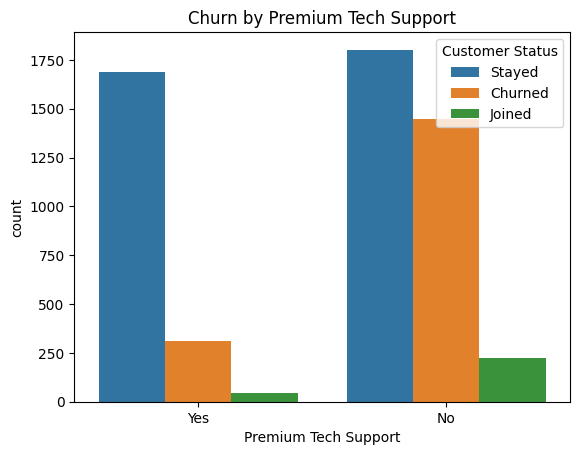

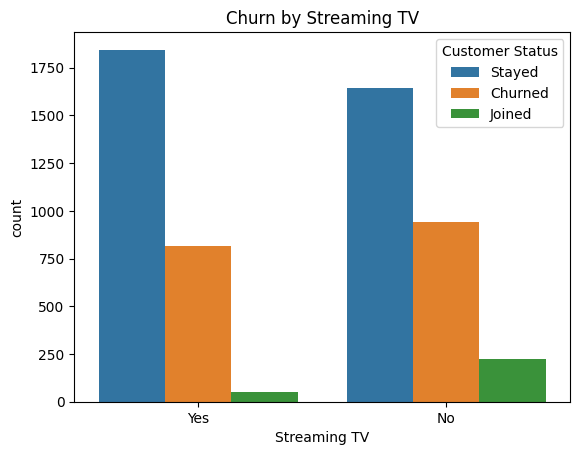

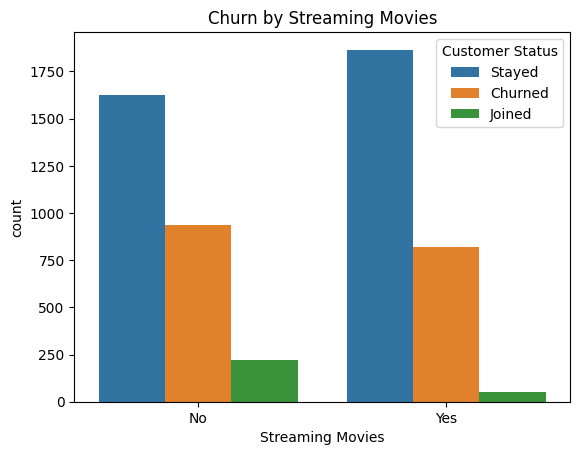

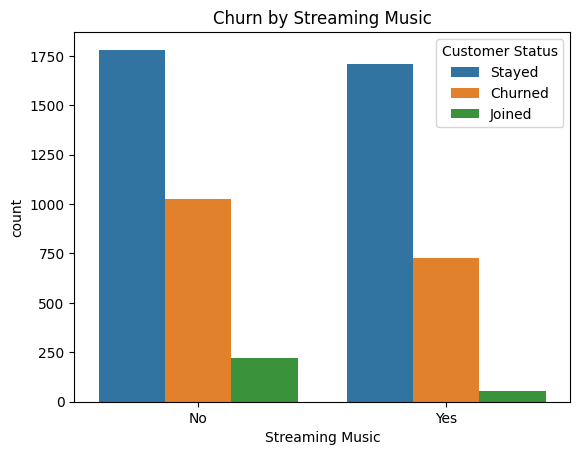

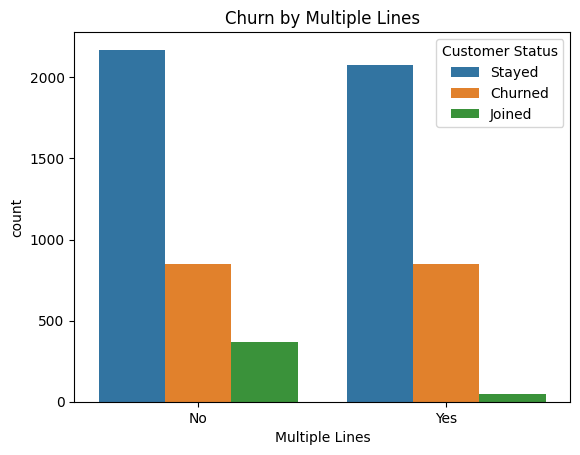

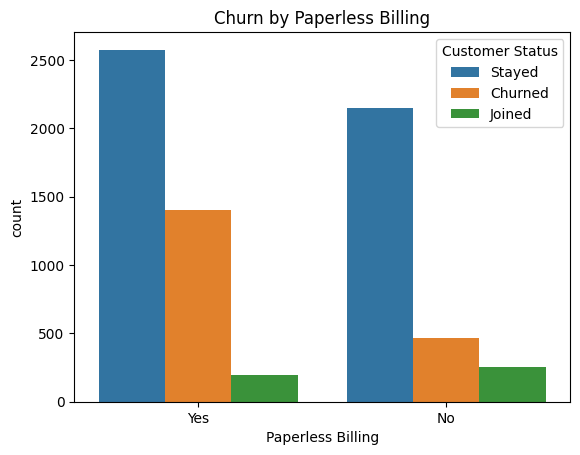

In [20]:
sns.countplot(x='Payment Method', hue='Customer Status', data=df_churn)
plt.title('Churn by Payment Method')
plt.show()

sns.boxplot(x='Customer Status', y='Tenure in Months', data=df_churn)
plt.title('Tenure in Months vs Customer Status')
plt.show()

sns.boxplot(x='Customer Status', y='Number of Dependents', data=df_churn)
plt.title('Churn by No. of Dependents')
plt.show()

sns.countplot(x='Internet Service', hue='Customer Status', data=df_churn)
plt.title('Churn by Internet Service')
plt.show()

sns.countplot(x='Contract', hue='Customer Status', data=df_churn)
plt.title('Churn by Contract Type')
plt.show()

sns.countplot(x='Offer', hue='Customer Status', data=df_churn)
plt.title('Churn by Offer')
plt.show()

sns.countplot(x='Payment Method', hue='Customer Status', data=df_churn)
plt.title('Churn by Payment Method')
plt.show()

service_features = ['Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support']

for feature in service_features:
    sns.countplot(x=feature, hue='Customer Status', data=df_churn)
    plt.title(f'Churn by {feature}')
    plt.show()

#streaming services
streaming_services = ['Streaming TV', 'Streaming Movies', 'Streaming Music']

for service in streaming_services:
    sns.countplot(x=service, hue='Customer Status', data=df_churn)
    plt.title(f'Churn by {service}')
    plt.show()
#lines
sns.countplot(x='Multiple Lines', hue='Customer Status', data=df_churn)
plt.title('Churn by Multiple Lines')
plt.show()

sns.countplot(x='Paperless Billing', hue='Customer Status', data=df_churn)
plt.title('Churn by Paperless Billing')
plt.show()


#**Numerical Features:**


*   Visualisation
*   Heatmap



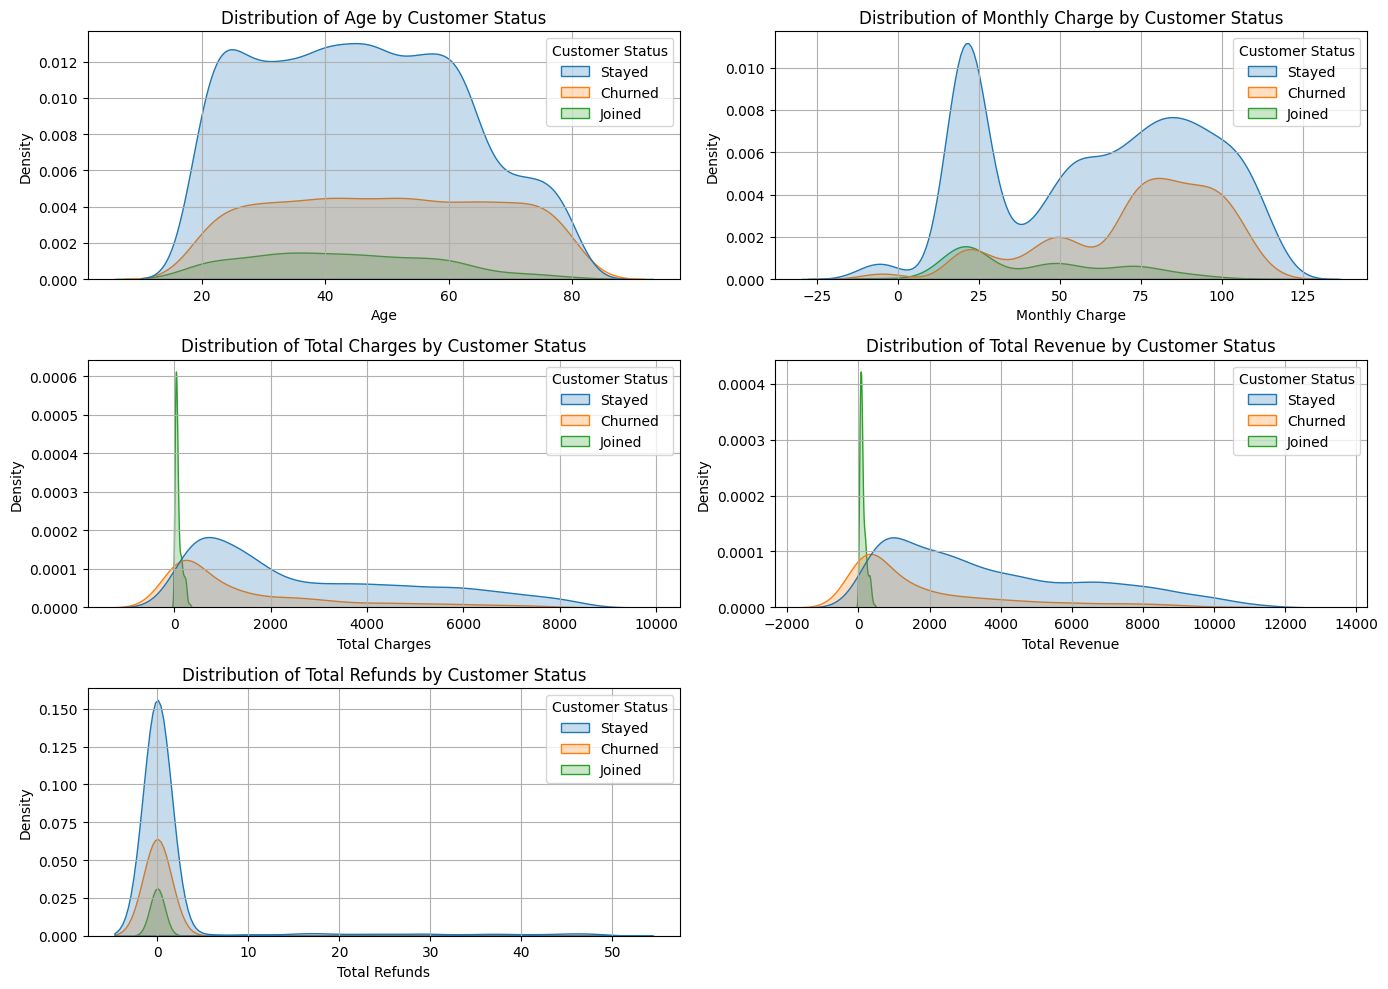

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = ['Age', 'Monthly Charge', 'Total Charges', 'Total Revenue', 'Total Refunds']
df_encoded = df_churn.copy()

plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)

    sns.kdeplot(data=df_encoded, x=feature, hue='Customer Status', fill=True)

    plt.title(f'Distribution of {feature} by Customer Status')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(True)

plt.tight_layout()
plt.show()

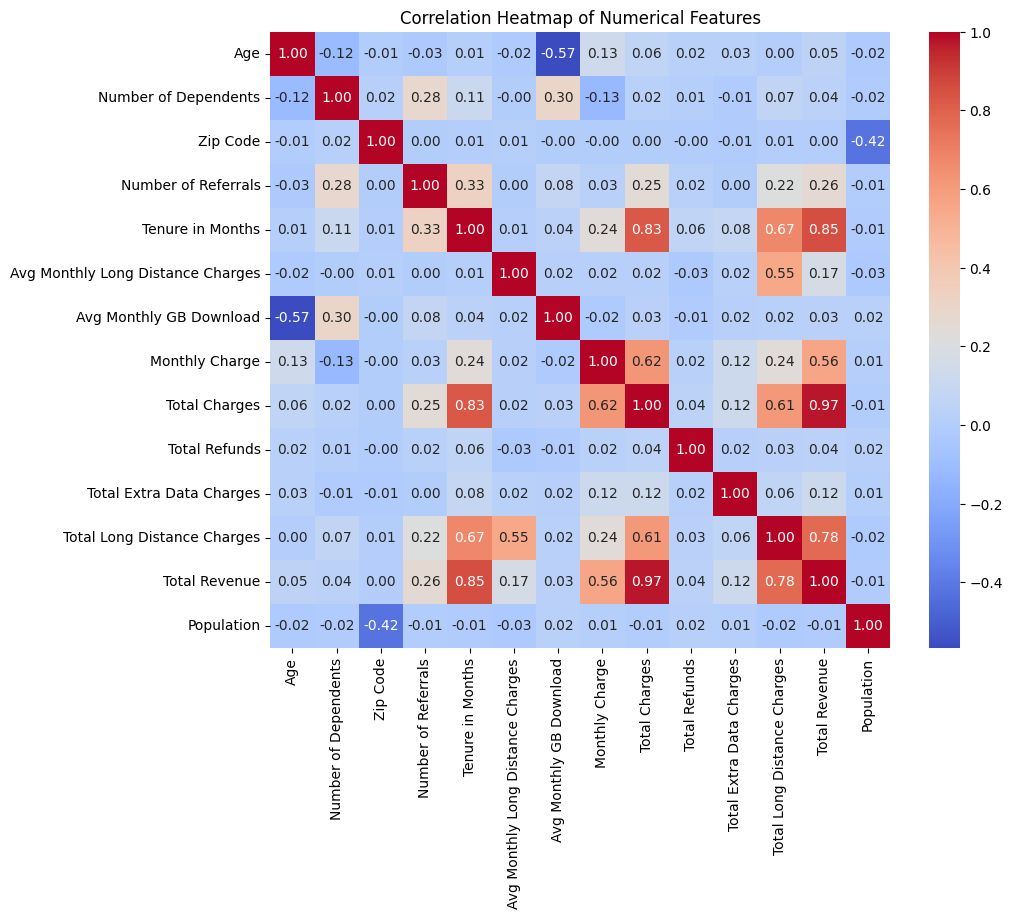

In [22]:
numeric_data = df_churn.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [23]:
# Removing the 'Total Charges' column as we can see that Total Charges and Total Revenue are highly correlative and suggest Multicollinearity
df_change = df_encoded.drop(columns=['Total Charges'])

df_change.head()

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Population
0,Female,37,Yes,0,93225,2,9,NaN,Yes,42.39,...,One Year,Yes,Credit Card,65.6,0.00,0,381.51,974.81,Stayed,4498
1,Male,46,No,0,91206,0,9,NaN,Yes,10.69,...,Month-to-Month,No,Credit Card,-4.0,38.33,10,96.21,610.28,Stayed,31297
2,Male,50,No,0,92627,0,4,Offer E,Yes,33.65,...,Month-to-Month,Yes,Bank Withdrawal,73.9,0.00,0,134.60,415.45,Churned,62069
3,Male,78,Yes,0,94553,1,13,Offer D,Yes,27.82,...,Month-to-Month,Yes,Bank Withdrawal,98.0,0.00,0,361.66,1599.51,Churned,46677
4,Female,75,Yes,0,93010,3,3,NaN,Yes,7.38,...,Month-to-Month,Yes,Credit Card,83.9,0.00,0,22.14,289.54,Churned,42853


Checking for skewness

In [24]:
skewness = numeric_data.apply(skew)

print("Skewness of numerical features:\n", skewness)

Skewness of numerical features:
 Age                                  0.162152
Number of Dependents                 2.109483
Zip Code                            -0.209570
Number of Referrals                  1.445752
Tenure in Months                     0.240491
Avg Monthly Long Distance Charges         NaN
Avg Monthly GB Download                   NaN
Monthly Charge                      -0.275335
Total Charges                        0.963586
Total Refunds                        4.327595
Total Extra Data Charges             4.090338
Total Long Distance Charges          1.238018
Total Revenue                        0.919214
Population                           0.912660
dtype: float64


**Applying Log transformation to features with high skewness**

In [25]:
#choosing ones with high skewness
columns_to_transform = ['Number of Dependents', 'Number of Referrals',
                        'Total Refunds', 'Total Extra Data Charges',
                        'Total Long Distance Charges']

log_skewness = df_change[columns_to_transform].apply(np.log1p)

new_skewness = log_skewness.skew()
print("Skewness after log transformation:\n", new_skewness)

Skewness after log transformation:
 Number of Dependents           1.591533
Number of Referrals            0.842100
Total Refunds                  3.486093
Total Extra Data Charges       2.854589
Total Long Distance Charges   -1.108455
dtype: float64


In [26]:
sqrt_transformed = df_change[columns_to_transform].apply(np.sqrt)
sqrt_skewness = sqrt_transformed.skew()
print("\nSkewness after square root transformation:\n", sqrt_skewness)


Skewness after square root transformation:
 Number of Dependents           1.504698
Number of Referrals            0.820685
Total Refunds                  3.694275
Total Extra Data Charges       3.272430
Total Long Distance Charges    0.384727
dtype: float64


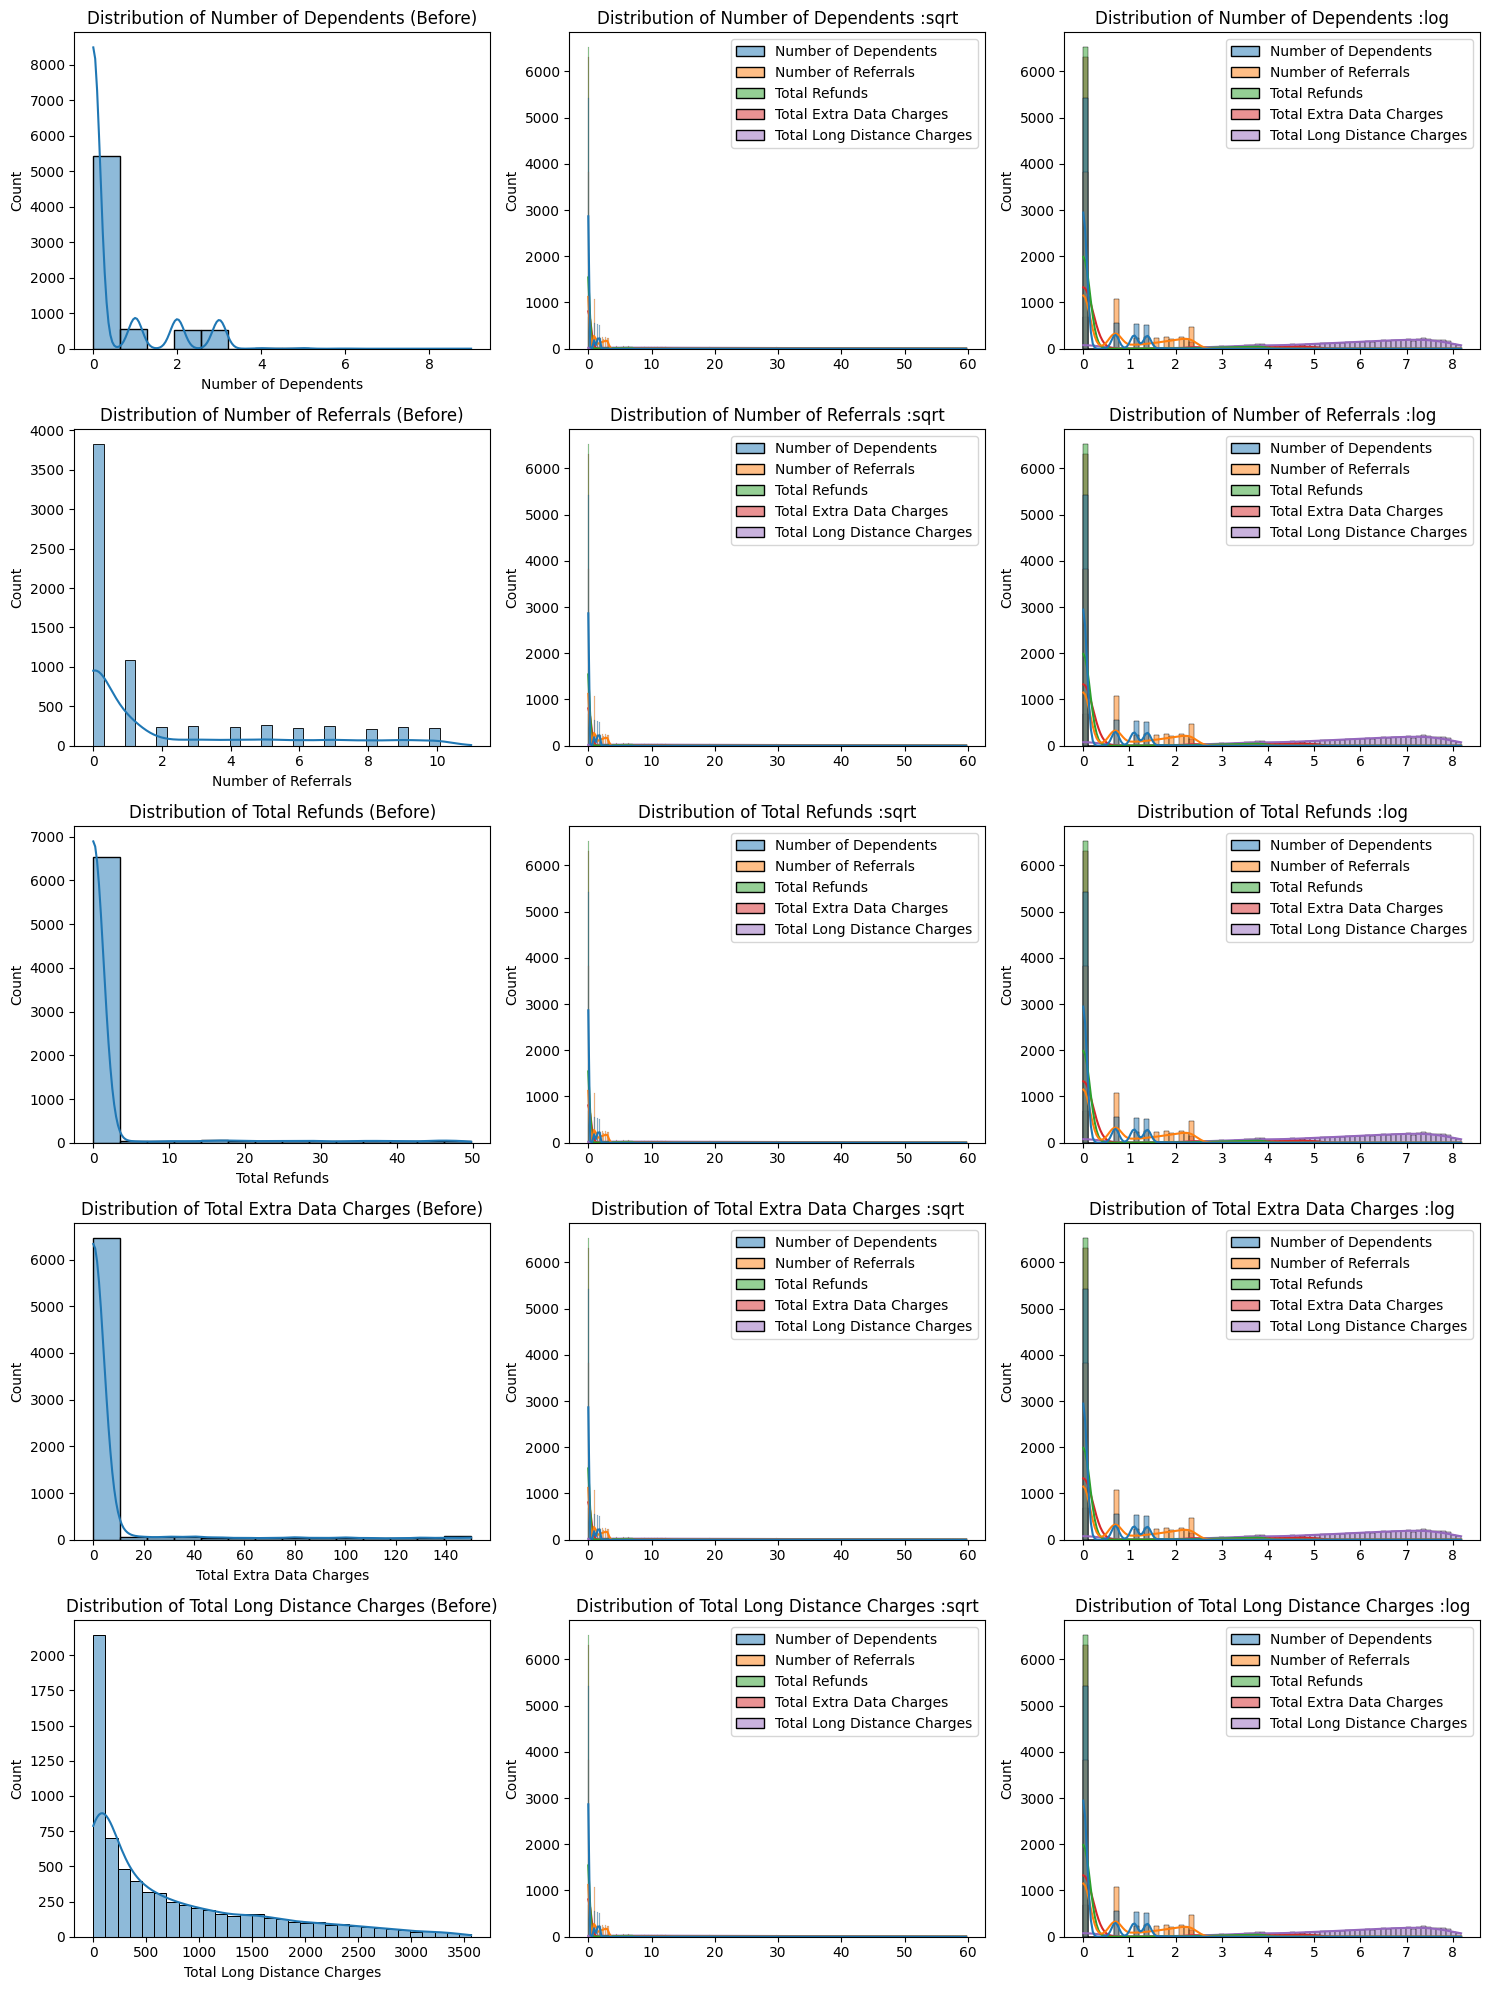

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

for i, column in enumerate(columns_to_transform):
    sns.histplot(df_change[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column} (Before)')

    sns.histplot(sqrt_transformed, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {column} :sqrt')
    sns.histplot(log_skewness, kde=True, ax=axes[i, 2])
    axes[i, 2].set_title(f'Distribution of {column} :log')

plt.tight_layout()
plt.show()

In [28]:
for column in columns_to_transform:
    df_change[f'{column} sqrt'] = np.sqrt(df_change[column])
    df_change[f'{column} log'] = np.log1p(df_change[column])

df_change.head()

,Gender,Age,Married,Number of Dependents,Zip Code,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Number of Dependents sqrt,Number of Dependents log,Number of Referrals sqrt,Number of Referrals log,Total Refunds sqrt,Total Refunds log,Total Extra Data Charges sqrt,Total Extra Data Charges log,Total Long Distance Charges sqrt,Total Long Distance Charges log
0,Female,37,Yes,0,93225,2,9,NaN,Yes,42.39,...,0.0,0.0,1.414214,1.098612,0.000000,0.000000,0.000000,0.000000,19.532281,5.946755
1,Male,46,No,0,91206,0,9,NaN,Yes,10.69,...,0.0,0.0,0.000000,0.000000,6.191123,3.671988,3.162278,2.397895,9.808670,4.576874
2,Male,50,No,0,92627,0,4,Offer E,Yes,33.65,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.601724,4.909709
3,Male,78,Yes,0,94553,1,13,Offer D,Yes,27.82,...,0.0,0.0,1.000000,0.693147,0.000000,0.000000,0.000000,0.000000,19.017360,5.893466
4,Female,75,Yes,0,93010,3,3,NaN,Yes,7.38,...,0.0,0.0,1.732051,1.386294,0.000000,0.000000,0.000000,0.000000,4.705316,3.141563


In [29]:
# Selecting categorical features
categorical_features = df_change.select_dtypes(include=['object'])

null_values_categorical = categorical_features.isnull().sum()

print("Null values in nominal features:")
print(null_values_categorical)

Null values in nominal features:
Gender                       0
Married                      0
Offer                     3877
Phone Service                0
Multiple Lines             682
Internet Service             0
Internet Type             1526
Online Security           1526
Online Backup             1526
Device Protection Plan    1526
Premium Tech Support      1526
Streaming TV              1526
Streaming Movies          1526
Streaming Music           1526
Unlimited Data            1526
Contract                     0
Paperless Billing            0
Payment Method               0
Customer Status              0
dtype: int64


In [30]:
internet_related_columns = [
    'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data'
]
for column in internet_related_columns:
    df_change[column] = df_change[column].apply(lambda x: 'no_internet_service' if pd.isnull(x) else x)

df_change['Offer'] = df_change['Offer'].apply(lambda x: 'no_offer' if pd.isnull(x) else x)

columns_to_fill = ['Avg Monthly Long Distance Charges', 'Avg Monthly GB Download']
for column in columns_to_fill:
    df_change[column] = df_change[column].apply(lambda x: 0 if pd.isnull(x) else x)


print("Remaining missing values after initial fill:")
print(df_change.isna().sum())

Remaining missing values after initial fill:
Gender                                 0
Age                                    0
Married                                0
Number of Dependents                   0
Zip Code                               0
Number of Referrals                    0
Tenure in Months                       0
Offer                                  0
Phone Service                          0
Avg Monthly Long Distance Charges      0
Multiple Lines                       682
Internet Service                       0
Internet Type                          0
Avg Monthly GB Download                0
Online Security                        0
Online Backup                          0
Device Protection Plan                 0
Premium Tech Support                   0
Streaming TV                           0
Streaming Movies                       0
Streaming Music                        0
Unlimited Data                         0
Contract                               0
Paperless Bi

**Now managing missing values in Multiple Lines column using kNN**

In [31]:
conversion_dict = {"Yes": 1, "No": 0}
df_change['Multiple Lines'] = df_change['Multiple Lines'].map(conversion_dict)

label_encoder = LabelEncoder()
df_change['Customer Status'] = label_encoder.fit_transform(df_change['Customer Status'])

df_change = pd.get_dummies(df_change, drop_first=True)

# KNN Imputer for 'Multiple Lines'
from sklearn.impute import KNNImputer

label = df_change['Customer Status']
df_change = df_change.drop(columns=['Customer Status'])

imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df_change)

df_change = pd.DataFrame(imputed_data, columns=df_change.columns)

df_change['Multiple Lines'] = df_change['Multiple Lines'].apply(lambda x: round(x))

df_change['Customer Status'] = label

print("Checking for missing values again:")
print(df_change.isna().sum().sort_values(ascending=False))

Checking for missing values again:
Age                                           0
Premium Tech Support_no_internet_service      0
Phone Service_Yes                             0
Internet Service_Yes                          0
Internet Type_DSL                             0
Internet Type_Fiber Optic                     0
Internet Type_no_internet_service             0
Online Security_Yes                           0
Online Security_no_internet_service           0
Online Backup_Yes                             0
Online Backup_no_internet_service             0
Device Protection Plan_Yes                    0
Device Protection Plan_no_internet_service    0
Premium Tech Support_Yes                      0
Streaming TV_Yes                              0
Number of Dependents                          0
Streaming TV_no_internet_service              0
Streaming Movies_Yes                          0
Streaming Movies_no_internet_service          0
Streaming Music_Yes                           0
Strea

**
No more missing values now!^^**

In [32]:
from sklearn.model_selection import train_test_split
# Features
X = df_change.drop(['Customer Status'], axis=1)
# Target
y = df_change['Customer Status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=df_change['Customer Status'])

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((5634, 57), (5634,), (1409, 57), (1409,))

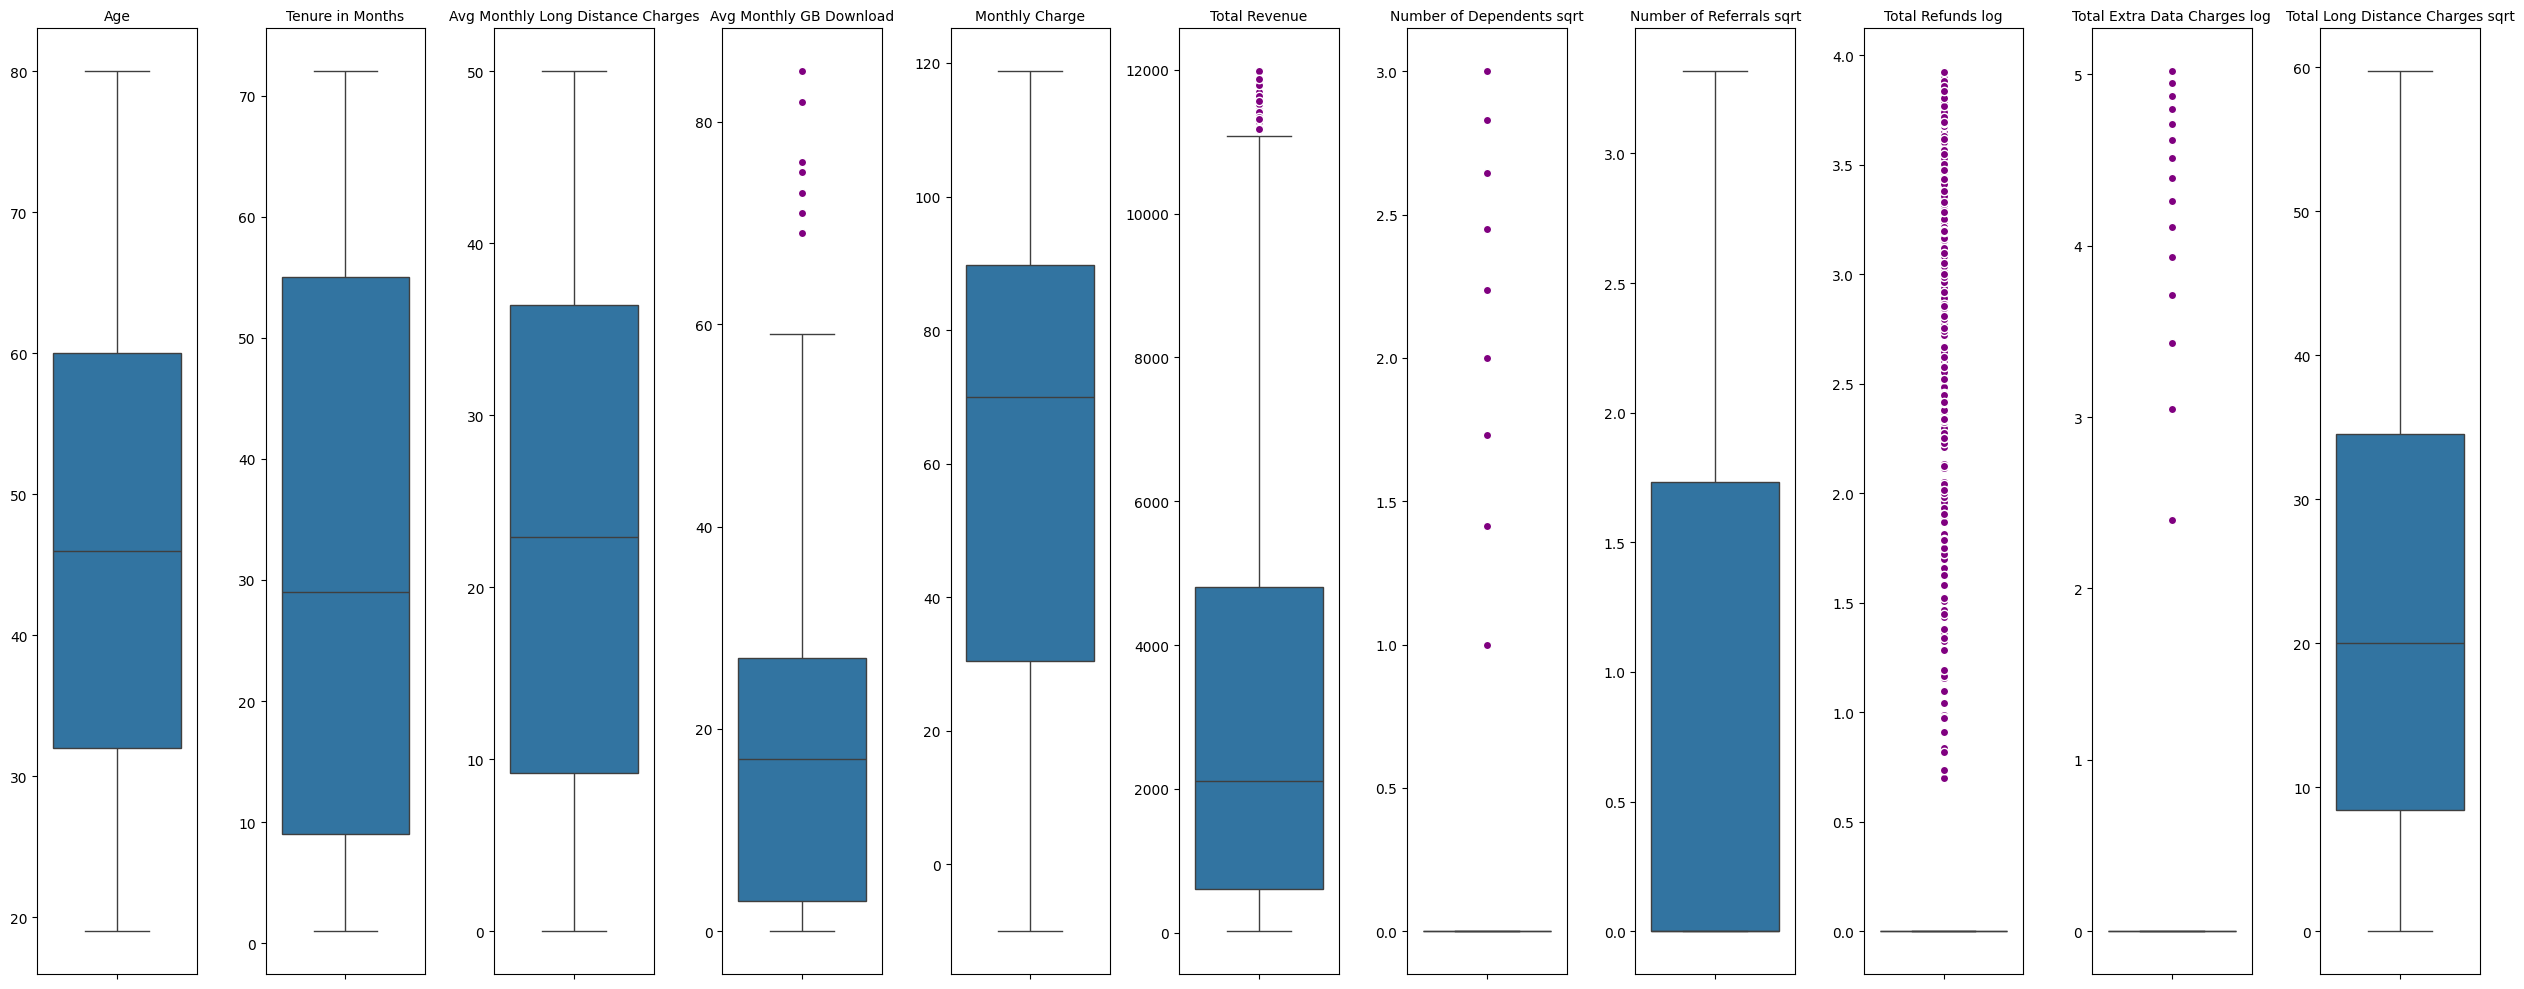

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


purple_circle = dict(markerfacecolor='purple', marker='o', markeredgecolor='white')
numerical_columns = [
    'Age', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
    'Monthly Charge', 'Total Revenue', 'Number of Dependents sqrt', 'Number of Referrals sqrt',
    'Total Refunds log', 'Total Extra Data Charges log', 'Total Long Distance Charges sqrt'
]

num_plots = len(numerical_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(25, 10))

for index, col in enumerate(numerical_columns):
    sns.boxplot(y=df_change[col], ax=axes[index], flierprops=purple_circle)
    axes[index].set_title(col, fontsize=10)
    axes[index].set_ylabel('')

plt.tight_layout()
plt.show()

In [34]:
def outlier_detection_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

outlier_detection = df_change[numerical_columns]

for col in outlier_detection.columns:
    outliers = outlier_detection_IQR(outlier_detection[col])
    percentage_outlier = len(outliers) * 100.0 / len(outlier_detection)
    print(f"Column: {col}")
    print(f"Number of Outliers: {len(outliers)}")
    print(f"% of Outliers: {percentage_outlier:.2f}%")
    print(f"Max Outlier Val: {outliers.max()}")
    print(f"Min Outlier Val: {outliers.min()}\n")


Column: Age
Number of Outliers: 0
% of Outliers: 0.00%
Max Outlier Val: nan
Min Outlier Val: nan

Column: Tenure in Months
Number of Outliers: 0
% of Outliers: 0.00%
Max Outlier Val: nan
Min Outlier Val: nan

Column: Avg Monthly Long Distance Charges
Number of Outliers: 0
% of Outliers: 0.00%
Max Outlier Val: nan
Min Outlier Val: nan

Column: Avg Monthly GB Download
Number of Outliers: 362
% of Outliers: 5.14%
Max Outlier Val: 85.0
Min Outlier Val: 69.0

Column: Monthly Charge
Number of Outliers: 0
% of Outliers: 0.00%
Max Outlier Val: nan
Min Outlier Val: nan

Column: Total Revenue
Number of Outliers: 21
% of Outliers: 0.30%
Max Outlier Val: 11979.34
Min Outlier Val: 11169.77

Column: Number of Dependents sqrt
Number of Outliers: 1627
% of Outliers: 23.10%
Max Outlier Val: 3.0
Min Outlier Val: 1.0

Column: Number of Referrals sqrt
Number of Outliers: 0
% of Outliers: 0.00%
Max Outlier Val: nan
Min Outlier Val: nan

Column: Total Refunds log
Number of Outliers: 525
% of Outliers: 7.45%

**Certain columns such as Avg Monthly GB Download and Total Refunds log and Total Revenue show outliers and these must be handled**

In [35]:
def handle_outliers(X_train, X_test, columns):
    for col in columns:
        Q1 = np.percentile(X_train[col], 25)
        Q3 = np.percentile(X_train[col], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])

        X_test[col] = np.where(X_test[col] < lower_bound, lower_bound, X_test[col])
        X_test[col] = np.where(X_test[col] > upper_bound, upper_bound, X_test[col])

    return X_train, X_test

columns_to_handle = [
    'Avg Monthly GB Download', 'Total Revenue', 'Number of Dependents sqrt',
    'Total Refunds log', 'Total Extra Data Charges log'
]

X_train, X_test = handle_outliers(X_train, X_test, columns_to_handle)


#Scaling

In [36]:
from imblearn.combine import SMOTETomek

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train_counts = pd.Series(y_train).value_counts()

print("These are the counts of each class in y_train:")
print(y_train_counts)

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print('Resampled training set shape:\n', pd.Series(y_train_resampled).value_counts())

These are the counts of each class in y_train:
2    3776
0    1495
1     363
Name: count, dtype: int64
Resampled training set shape:
 1    3592
2    3318
0    3284
Name: count, dtype: int64


#Model Training: XGBoost

In [37]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)

grid_search_xgb.fit(X_train_resampled, y_train_resampled)
best_params = grid_search_xgb.best_params_
best_score = grid_search_xgb.best_score_

print(f"Best parameters in the XGBoost model: {best_params}")
print(f"Best cross-validation score in the XGBoost model: {best_score}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:22:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters in the XGBoost model: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score in the XGBoost model: 0.9205340515887341


#Evaluation

In [38]:
best_model = grid_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)

target_names = {0: 'Churned', 1: 'Joined', 2: 'Stayed'}
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[target_names[i] for i in sorted(target_names)]))

print("Here is the Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Churned       0.73      0.68      0.70       374
      Joined       0.72      0.69      0.71        91
      Stayed       0.90      0.93      0.91       944

    accuracy                           0.85      1409
   macro avg       0.78      0.77      0.78      1409
weighted avg       0.84      0.85      0.85      1409

Here is the Confusion Matrix:
[[254  24  96]
 [ 28  63   0]
 [ 67   0 877]]
